In [1]:
# !/usr/bin/python
# -*- coding:utf-8 -*-

import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics.pairwise import pairwise_distances_argmin
import warnings

In [2]:
def expand(a, b):
    return 1.05*a-0.05*b, 1.05*b-0.05*a

初始概率： [ 0.19356424  0.25224431  0.21259213  0.19217803  0.14942128]
转移概率：
[[ 0.25822029  0.          0.35651955  0.38526017  0.        ]
 [ 0.          0.34669639  0.          0.6067387   0.04656491]
 [ 0.04868208  0.          0.46521279  0.          0.48610513]
 [ 0.3825259   0.31237801  0.          0.30509609  0.        ]
 [ 0.          0.09539815  0.62865435  0.          0.2759475 ]]
[[ 30.  30.  30.]
 [  0.  50.  20.]
 [-25.  30.  10.]
 [-15.   0.  25.]
 [ 15.   0.  40.]]
均值：
[[ 0.57735027  0.57735027  0.57735027]
 [ 0.          0.92847669  0.37139068]
 [-0.62017367  0.74420841  0.24806947]
 [-0.51449576  0.          0.85749293]
 [ 0.35112344  0.          0.93632918]]
方差：
[[[ 0.00629111  0.          0.        ]
  [ 0.          0.01648467  0.        ]
  [ 0.          0.          0.01012301]]

 [[ 0.01236868  0.          0.        ]
  [ 0.          0.0013758   0.        ]
  [ 0.          0.          0.01335271]]

 [[ 0.01324191  0.          0.        ]
  [ 0.          0.01333868  0. 

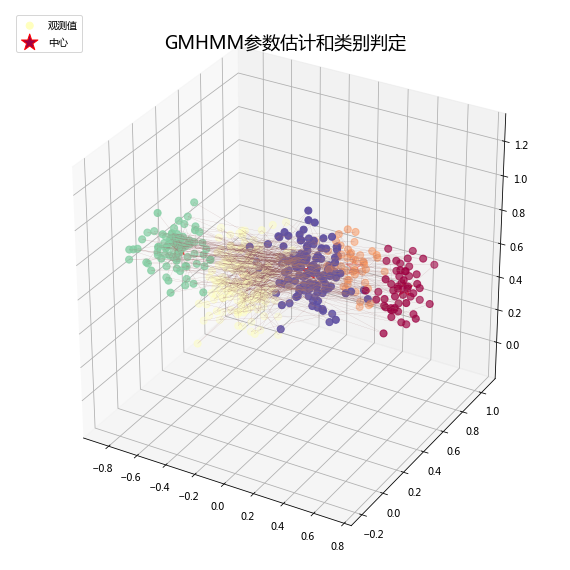

In [3]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore")   # hmmlearn(0.2.0) < sklearn(0.18)
    np.random.seed(0)

    n = 5   # 隐状态数目
    n_samples = 500
    pi = np.random.rand(n)
    pi /= pi.sum()
    print '初始概率：', pi

    A = np.random.rand(n, n)
    mask = np.zeros((n, n), dtype=np.bool)
    mask[0][1] = mask[0][4] = True
    mask[1][0] = mask[1][2] = True
    mask[2][1] = mask[2][3] = True
    mask[3][2] = mask[3][4] = True
    mask[4][0] = mask[4][3] = True
    A[mask] = 0
    for i in range(n):
        A[i] /= A[i].sum()
    print '转移概率：\n', A

    means = np.array(((30, 30, 30), (0, 50, 20), (-25, 30, 10), (-15, 0, 25), (15, 0, 40)), dtype=np.float)
    # means = np.random.rand(5, 3)
    print means
    for i in range(n):
        means[i,:] /= np.sqrt(np.sum(means ** 2, axis=1))[i]
    print '均值：\n', means

    covars = np.empty((n, 3, 3))
    for i in range(n):
        # covars[i] = np.diag(np.random.randint(1, 5, size=2))
        covars[i] = np.diag(np.random.rand(3)*0.02+0.001)    # np.random.rand ∈[0,1)
    print '方差：\n', covars

    model = hmm.GaussianHMM(n_components=n, covariance_type='full')
    model.startprob_ = pi
    model.transmat_ = A
    model.means_ = means
    model.covars_ = covars
    sample, labels = model.sample(n_samples=n_samples, random_state=0)

    # 估计参数
    model = hmm.GaussianHMM(n_components=n, covariance_type='full', n_iter=10)
    model.fit(sample)
    y = model.predict(sample)
    np.set_printoptions(suppress=True)
    print '##估计初始概率：', model.startprob_
    print '##估计转移概率：\n', model.transmat_
    print '##估计均值：\n', model.means_
    print '##估计方差：\n', model.covars_

    # 类别
    order = pairwise_distances_argmin(means, model.means_, metric='euclidean')
    print order
    pi_hat = model.startprob_[order]
    A_hat = model.transmat_[order]
    A_hat = A_hat[:, order]
    means_hat = model.means_[order]
    covars_hat = model.covars_[order]
    change = np.empty((n, n_samples), dtype=np.bool)
    for i in range(n):
        change[i] = y == order[i]
    for i in range(n):
        y[change[i]] = i
    print '估计初始概率：', pi_hat
    print '估计转移概率：\n', A_hat
    print '估计均值：\n', means_hat
    print '估计方差：\n', covars_hat
    print labels
    print y
    acc = np.mean(labels == y) * 100
    print '准确率：%.2f%%' % acc

    # mpl.rcParams['font.sans-serif'] = [u'SimHei']
    # mpl.rcParams['axes.unicode_minus'] = False
    fig = plt.figure(figsize=(8, 8), facecolor='w')
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.Spectral(np.linspace(0,1,n))
    ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], s=50, c=labels, cmap=plt.cm.Spectral, marker='o', label=u'观测值', depthshade=True)
    plt.plot(sample[:, 0], sample[:, 1], sample[:, 2], lw=0.1, color='#A07070')
    colors = plt.cm.Spectral(np.linspace(0, 1, n))
    ax.scatter(means[:, 0], means[:, 1], means[:, 2], s=300, c=colors, edgecolor='r', linewidths=1, marker='*', label=u'中心')

    x_min, y_min, z_min = sample.min(axis=0)
    x_max, y_max, z_max = sample.max(axis=0)
    x_min, x_max = expand(x_min, x_max)
    y_min, y_max = expand(y_min, y_max)
    z_min, z_max = expand(z_min, z_max)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.set_zlim((z_min, z_max))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout(1)
    plt.title(u'GMHMM参数估计和类别判定', fontsize=18)
    plt.show()